In [1]:
"""
Epipolar Constraints for Self-Supervised Keypoint Detection

@author: Ganesh Sistu
"""
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

# Use any pair of images captured from the same camera with an unknown
# transformation matrix R/t (will be calculated as part of the essential matrix)

K = np.array([[391.469, 0, 192],
              [0, 342.976, 112],
              [0, 0, 1]])

img1 = cv2.imread('DSCF4668.JPG')
img2 = cv2.imread('DSCF4669.JPG')
# Resize images
dim = (384, 224)
image1 = cv2.resize(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB), dim)
image2 = cv2.resize(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB), dim)

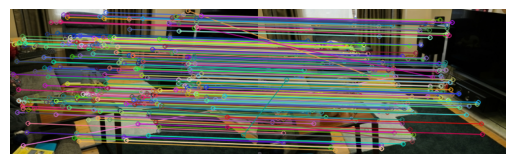

Essential Matrix:
 [[-0.00088934  0.14299659  0.08013204]
 [-0.15212502  0.01851703 -0.68611706]
 [-0.08366035  0.68662075  0.02100973]]


In [2]:
def find_essential_matrix(img1, img2, K):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

    # FLANN parameters and matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Filter matches using the Lowe's ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)
    # Draw the good matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good, None, flags=2)
    plt.imshow(img_matches)
    plt.axis('off')  # Turn off axis numbers
    plt.show()
    # Minimum number of matches
    MIN_MATCH_COUNT = 10
    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

        # Compute the Essential Matrix
        E, mask = cv2.findEssentialMat(src_pts, dst_pts, K)
        return E
    else:
        print(f"Not enough matches are found - {len(good)}/{MIN_MATCH_COUNT}")
        return None

# find the essential matrix
essential_matrix = find_essential_matrix(image1, image2, K)
print("Essential Matrix:\n", essential_matrix)


In [3]:
from superpoint import SuperPoint
config = {
        'superpoint': {
            'nms_radius': 4,
            'keypoint_threshold': 0.005,
            'max_keypoints': -1
        }
}

In [4]:
import torch
import torch.nn.functional as F
from torchvision import models

class KpPostProcess(torch.nn.Module):

    def __init__(self, grid_size, scale_factor):
        super(KpPostProcess, self).__init__()
        self.scale_factor = scale_factor
        self.grid_size = grid_size

    def forward(self, features):
        batch_size, channels, height, width = features.size()
        # Generate grid indices
        h_indices = torch.arange(0, height, grid_size)
        w_indices = torch.arange(0, width, grid_size)
        h_grid, w_grid = torch.meshgrid(h_indices, w_indices, indexing='ij')
        grid_indices = torch.stack([h_grid, w_grid], dim=-1).reshape(-1, 2)  # Shape: [num_grids, 2]
        # Initialize keypoints and descriptors
        num_grids = grid_indices.shape[0]
        keypoints = torch.zeros((batch_size, num_grids, 2)).float()
        keypoints_probs = torch.zeros((batch_size, num_grids, 1)).float()

        descriptors = torch.zeros((batch_size, num_grids, channels))

        # Reshape features for batch processing
        features_reshaped = features.view(batch_size, channels, -1)  # Shape: [batch_size, channels, H*W]

        # Process each grid cell
        for i, (h, w) in enumerate(grid_indices):
            grid = features[:, :, h:h+grid_size, w:w+grid_size]
            grid_flat = grid.reshape(batch_size, channels, -1)  # Flatten the grid
            grid_mean = grid_flat.mean(dim=1)  # does this mean taking average of features?

            # Compute keypoint probabilities and get max indices
            keypoint_probs = F.softmax(grid_mean, dim=1)
            max_idxs = keypoint_probs.argmax(dim=1,keepdim=True)
            # Calculate (x, y) coordinates of keypoints
            y_coords = (h + max_idxs // grid_size).float() * scale_factor
            x_coords = (w + max_idxs % grid_size).float() * scale_factor
            keypoints[:, i, :] = torch.stack([y_coords, x_coords], dim=1)[:,:,0]
            keypoints_probs[:, i, :] = keypoint_probs.max(dim=1,keepdim=True).values
            # Extract descriptors
            row = max_idxs // grid_size
            col = max_idxs % grid_size
            descriptors[:,i, :] = grid[:, :, row, col][:, :, 0, 0]

        return keypoints, descriptors, keypoints_probs

class KpFeatures(torch.nn.Module):

    def __init__(self, grid_size, scale_factor):
        super(KpFeatures, self).__init__()
#         # Instantiate ResNet-18 without the final fully connected layer
#         resnet18 = models.resnet18(pretrained=True)
#         self.resnet18 = torch.nn.Sequential(*list(resnet18.children())[:-2])
#         self.deconv1 = torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
#         self.deconv2 = torch.nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
#         self.batch_norm = torch.nn.BatchNorm2d(256)
        self.model = SuperPoint(config)
        self.post_process = KpPostProcess(grid_size, scale_factor)
    def forward(self, x):
#         # feature extractor
#         x = self.resnet18(x)
#         x = self.deconv1(x)
#         x = self.batch_norm(x)
#         x = self.deconv2(x)
#         # keypoint extraction
#         keypoints, descriptors, keypoints_probs = self.post_process(x)
        x = self.model(x)
        keypoints, descriptors, keypoints_probs = self.post_process(x['descriptors'])
        return keypoints, descriptors, keypoints_probs
#         return torch.stack(x['keypoints']), torch.transpose(torch.stack(x['descriptors']), 1, 2), torch.stack(x['scores']).unsqueeze(dim = 2)


def normalize_keypoints(points, K_inv):
    """
    Normalize keypoints using the inverse camera intrinsic matrix.
    Assumes points are in the shape [batch_size, num_points, 2]
    K_inv is assumed to be [3, 3]
    """
    batch_size, num_points, _ = points.shape

    # Convert to homogeneous coordinates [batch_size, num_points, 3]
    ones = torch.ones(batch_size, num_points, 1, device=points.device)
    homogeneous_points = torch.cat([points, ones], dim=2)

    # Apply K_inv to each point
    # Reshape K_inv to broadcast across the batch
    K_inv_batch = K_inv.unsqueeze(0).repeat(batch_size, 1, 1)

    # Batch matrix multiplication
    normalized_points = torch.bmm(homogeneous_points, K_inv_batch.transpose(1, 2))

    return normalized_points


def sinkhorn_iterations(scores, max_iterations=20, epsilon=1e-3):
    # Apply Sinkhorn iterations for each element in the batch
    for _ in range(max_iterations):
        # Row normalization - ensure normalization is done for each batch separately
        scores = torch.nn.functional.softmax(scores, dim=2)

        # Column normalization - again, separate for each batch
        scores = torch.nn.functional.softmax(scores, dim=1)
    return scores

def contrastive_loss(desc1, desc2, soft_assignment, margin=1.0):
    batch_size, num_points, _ = desc1.shape

    # Calculate the pairwise distance matrix for each batch
    pairwise_distances = torch.cdist(desc1, desc2, p=2)  # Shape: [batch_size, num_points, num_points]

    # Positive pairs: Use soft_assignment as weights for the distances
    positive_loss = torch.sum(soft_assignment * pairwise_distances) / batch_size

    # Negative pairs: Push apart pairs with low assignment probability
    negative_loss = torch.sum((1 - soft_assignment) * torch.clamp(margin - pairwise_distances, min=0)) / batch_size

    loss = positive_loss + 0.5 * negative_loss
    return loss


def sampson_distance(points1, points2, E):
    """
    Compute the Sampson distance for batched points and a single Essential Matrix.
    Assumes points1 and points2 are normalized and in homogeneous coordinates,
    with shape [batch_size, total_points, 3].
    E is the Essential Matrix with shape [3, 3].
    """
    # Ensure E is transposed correctly for batch matrix multiplication
    E_transposed = E.transpose(0, 1)  # Should be [3, 3]

    # Apply Essential Matrix to the points
    Fx1 = torch.bmm(points1, E_transposed.unsqueeze(0).repeat(points1.size(0), 1, 1))  # [batch_size, total_points, 3]
    Fx2 = torch.bmm(points2, E.unsqueeze(0).repeat(points2.size(0), 1, 1))             # [batch_size, total_points, 3]

    # Compute the error terms
    errors = (points2 * Fx1).sum(dim=2)  # [batch_size, total_points]

    # Compute the denominator
    denom = Fx1[:, :, 0]**2 + Fx1[:, :, 1]**2 + Fx2[:, :, 0]**2 + Fx2[:, :, 1]**2  # [batch_size, total_points]

    # Compute the Sampson distance
    sampson_dist = (errors**2 / denom).sum(dim=1)  # Sum over points, [batch_size]

    return sampson_dist  # Returns a tensor of shape [batch_size]


def ep_loss(desc1, desc2, points1, points2, K, E, alpha = 0.5, margin=1.0):
    # Descriptor similarity (Euclidean distance as an example)
    desc_distance = torch.cdist(desc1, desc2)
    desc_similarity = torch.nn.functional.softmax(-desc_distance, dim=2)
    soft_assignment = torch.softmax(desc_similarity, dim=1)
#     print('soft_assignment', soft_assignment.shape)
    match_indices = torch.argmax(soft_assignment, dim=1)
	  # Create a range tensor for batch indexing
    batch_indices = torch.arange(points2.size(0)).unsqueeze(1)
    # Use torch.gather to align points2 according to match_indices
    aligned_points2 = torch.gather(points2, 1, match_indices.unsqueeze(-1).expand(-1, -1, points2.size(-1)))
    # Normalize keypoints
    K_inv = torch.inverse(K)  # Inverse of camera intrinsic matrix
    normalized_points1 = normalize_keypoints(points1, K_inv)
    normalized_aligned_points2 = normalize_keypoints(aligned_points2, K_inv)

    # Step 3: Calculate Sampson Distance for Geometric Loss
    geometric_loss = sampson_distance(normalized_points1, normalized_aligned_points2, E)

    # Descriptor loss (can be based on soft_assignment)
    descriptor_loss = contrastive_loss(desc1, desc2, soft_assignment, margin=1.0)

    # Combined loss
    combined_loss = alpha * descriptor_loss + (1 - alpha) * geometric_loss

    return combined_loss

# Function to move tensor to GPU if available
def move_to_gpu(tensor):
    if torch.cuda.is_available():
        tensor = tensor.cuda()
    return tensor

# Function to convert a tensor to a numpy array
def tensor_to_numpy(tensor):
    # Move tensor to cpu first if it's on GPU
    if tensor.is_cuda:
        tensor = tensor.cpu()
    return tensor.numpy()


def filter_and_pad_points(prob_tensor, tensor1, tensor2, thresh=0.3, pad_value=0):
    """
    Filters the points in tensor1 and tensor2 across all batches at once based on the
    probability score threshold in prob_tensor, and pads the results to ensure equal size.
    """
    print('prob_tensor:', prob_tensor.shape)
    print('tensor1:', tensor1.shape)
    print('tensor2:', tensor2.shape)
    batch_size, total_points, _ = prob_tensor.shape

    # Initialize lists to store filtered results
    filtered_tensor1_list = []
    filtered_tensor2_list = []

    # Filter each batch separately
    for b in range(batch_size):
        mask = prob_tensor[b, :, 0] > thresh
        filtered_tensor1_list.append(tensor1[b, mask].unsqueeze(0))  # Add a new dimension
        filtered_tensor2_list.append(tensor2[b, mask].unsqueeze(0))  # Add a new dimension

    # Concatenate the filtered results along a new dimension
    concatenated_tensor1 = torch.cat(filtered_tensor1_list, dim=0)
    concatenated_tensor2 = torch.cat(filtered_tensor2_list, dim=0)

    return concatenated_tensor1, concatenated_tensor2

In [5]:
# Define grid size and scale factor
grid_size = 3 # change based on the image encoder
scale_factor = 8 # depends on the image encoder

# pytorch data preparation
opencv_image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
opencv_image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
opencv_image11 = np.expand_dims(opencv_image1, axis = 0)
opencv_image22 = np.expand_dims(opencv_image2, axis = 0)
# # Rearrange the axes to [C, H, W]
# opencv_image1 = np.transpose(image1, (2, 0, 1))
# Convert to a float tensor
input1 = torch.unsqueeze(torch.from_numpy(opencv_image11).float(), dim=0)
# input1 = torch.unsqueeze(input1, dim = 0)

# # Rearrange the axes to [C, H, W]
# opencv_image2 = np.transpose(image2, (2, 0, 1))
# Convert to a float tensor
input2 = torch.unsqueeze(torch.from_numpy(opencv_image22).float(), dim=0)
# input2 = torch.unsqueeze(input2, dim = 0)

E = torch.from_numpy(essential_matrix).float()

K = torch.from_numpy(K).float()

In [6]:
kp_net = KpFeatures(grid_size, scale_factor)
move_to_gpu(kp_net)
learning_rate = 1e-4
optimizer = torch.optim.RMSprop(kp_net.parameters(), lr=learning_rate)

Loaded SuperPoint model


prob_tensor: torch.Size([1, 160, 1])
tensor1: torch.Size([1, 160, 2])
tensor2: torch.Size([1, 160, 256])
prob_tensor: torch.Size([1, 160, 1])
tensor1: torch.Size([1, 160, 2])
tensor2: torch.Size([1, 160, 256])
matches: (< cv2.DMatch 0x7f149cd5ae10>, < cv2.DMatch 0x7f149cd5aaf0>, < cv2.DMatch 0x7f149cd5aad0>, < cv2.DMatch 0x7f149cd5a930>, < cv2.DMatch 0x7f149cd5af10>, < cv2.DMatch 0x7f149cd5aa50>, < cv2.DMatch 0x7f149cd5aa10>, < cv2.DMatch 0x7f149cd5a950>, < cv2.DMatch 0x7f149cd5aab0>, < cv2.DMatch 0x7f149cd5acd0>, < cv2.DMatch 0x7f149cd5aef0>, < cv2.DMatch 0x7f149cd5aa70>, < cv2.DMatch 0x7f149cd5aa90>, < cv2.DMatch 0x7f149cd5ad50>, < cv2.DMatch 0x7f149cd5ac70>, < cv2.DMatch 0x7f149cd5adf0>)
keypoints1: [< cv2.KeyPoint 0x7f14d0574030>, < cv2.KeyPoint 0x7f14d05740c0>, < cv2.KeyPoint 0x7f14d0575fb0>, < cv2.KeyPoint 0x7f14d0576550>, < cv2.KeyPoint 0x7f14d0575b30>, < cv2.KeyPoint 0x7f14d0575800>, < cv2.KeyPoint 0x7f14d0574270>, < cv2.KeyPoint 0x7f14d0574ab0>, < cv2.KeyPoint 0x7f14d0575140>,

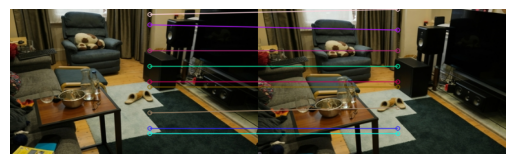

In [7]:
def convert_keypoints(keypoints_array, size=1.0):
    """Converts numpy array keypoints to a list of cv2.KeyPoint objects."""
    return [cv2.KeyPoint(x=float(kp[0]), y=float(kp[1]), size=size) for kp in keypoints_array.reshape(-1, 2)]


kp_net.eval()

with torch.no_grad():
    kp_1, d_1, kp_prob1 = kp_net(move_to_gpu(input1))
    kp_2, d_2, kp_prob2 = kp_net(move_to_gpu(input2))

kp_1, d_1 = filter_and_pad_points(kp_prob1, kp_1, d_1, 0.2)
kp_2, d_2 = filter_and_pad_points(kp_prob2, kp_2, d_2, 0.2)

infer_keypoints1 = kp_1.detach().cpu().numpy()
infer_keypoints2 = kp_2.detach().cpu().numpy()

# Convert numpy array keypoints to list of cv2.KeyPoint objects
keypoints1 = convert_keypoints(infer_keypoints1)
keypoints2 = convert_keypoints(infer_keypoints2)

# Create a BFMatcher object
# Choose the appropriate norm type depending on your descriptor
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match( tensor_to_numpy(d_1).reshape(-1, 256), tensor_to_numpy(d_2).reshape(-1, 256))
print('matches:', matches)
print('keypoints1:', keypoints1)
print('keypoints2:', keypoints2)
# Apply Lowe's ratio
ratio_threshold = 0.75  # Can be adjusted, common values are in the range 0.7 to 0.8
# good_matches = [m for m, n in matches if m.distance < ratio_threshold * n.distance]

# Draw the top N matches
try:
    img_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None, flags=2)
except:
    print("****************** ERROR DUE TO RANDOM MATCHES: TRY AFTER 10 EPOCHS ********************")

# Display the image
plt.imshow(img_matches)
plt.axis('off')  # Turn off axis numbers
plt.show()


In [8]:
# K = K.cuda()
# E = E.cuda()
kp_net.train()
for i in range(500): # changed from 500 to 5000
    keypoints1, des1, kp_prob1 = kp_net(move_to_gpu(input1))
    keypoints2, des2, kp_prob2 = kp_net(move_to_gpu(input2))
    optimizer.zero_grad()
    combined_loss = ep_loss(des1, des2, keypoints1, keypoints2, K, E, alpha = 0.5, margin=1.0)
    if i % 100 == 99:
        print("epoch", i, combined_loss.item())
    combined_loss.backward()
    optimizer.step()

epoch 99 102.76460266113281
epoch 199 98.46857452392578
epoch 299 107.11833953857422
epoch 399 97.75299835205078
epoch 499 98.17658996582031


prob_tensor: torch.Size([1, 160, 1])
tensor1: torch.Size([1, 160, 2])
tensor2: torch.Size([1, 160, 256])
prob_tensor: torch.Size([1, 160, 1])
tensor1: torch.Size([1, 160, 2])
tensor2: torch.Size([1, 160, 256])


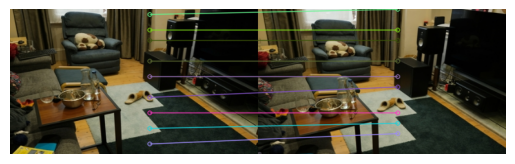

In [9]:
kp_net.eval()

with torch.no_grad():
  kp_1, d_1, kp_prob1 = kp_net(move_to_gpu(input1))
  kp_2, d_2, kp_prob2 = kp_net(move_to_gpu(input2))

kp_1, d_1 = filter_and_pad_points(kp_prob1, kp_1, d_1, 0.2)
kp_2, d_2 = filter_and_pad_points(kp_prob2, kp_2, d_2, 0.2)

infer_keypoints1 = kp_1.detach().numpy()
infer_keypoints2 = kp_2.detach().numpy()


def convert_keypoints(keypoints_array, size=1.0):
    """Converts numpy array keypoints to a list of cv2.KeyPoint objects."""
    return [cv2.KeyPoint(x=float(kp[0]), y=float(kp[1]), size=size) for kp in keypoints_array.reshape(-1, 2)]

# Convert numpy array keypoints to list of cv2.KeyPoint objects
keypoints1 = convert_keypoints(infer_keypoints1)
keypoints2 = convert_keypoints(infer_keypoints2)

# Create a BFMatcher object
# Choose the appropriate norm type depending on your descriptor
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match( tensor_to_numpy(d_1).reshape(-1, 256), tensor_to_numpy(d_2).reshape(-1, 256))

# Apply Lowe's ratio test
ratio_threshold = 0.75  # Can be adjusted, common values are in the range 0.7 to 0.8
# good_matches = [m for m, n in matches if m.distance < ratio_threshold * n.distance]

# Draw the top N matches
img_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches, None, flags=2)

# Display the result
# Display the image
plt.imshow(img_matches)
plt.axis('off')  # Turn off axis numbers
plt.show()
